# Notebook to train a DNN for card play

### Libraries

We use the keras library for building, training and evaluating the network. A tutorial for keras can be found on (https://keras.io/) or https://www.tensorflow.org/guide/keras. There are different implementations of keras, here I will use the one build on tensorflow.


In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

Create dataframe with all the better than average player

In [31]:
df_stat = pd.read_json("data/stat/player_all_stat.json")
df_stat = df_stat.sort_values(by='mean', ascending=False)
mean = df_stat['mean'].mean()
df_stat = df_stat.drop(df_stat[df_stat['mean'] < mean+15].index)
df_stat.head()

,id,mean,std,nr
4563,30505,140.000000,0.000000,1
4476,78140,117.200000,39.448701,5
4540,50172,116.666667,35.803166,6
4485,9797,115.857143,35.324347,7
2988,51264,115.000000,35.853870,5


In [32]:
cards = [
    # Diamonds
    'DA', 'DK', 'DQ', 'DJ', 'D10', 'D9', 'D8', 'D7', 'D6',
    # Hearts
    'HA', 'HK', 'HQ', 'HJ', 'H10', 'H9', 'H8', 'H7', 'H6',
    # Spades
    'SA', 'SK', 'SQ', 'SJ', 'S10', 'S9', 'S8', 'S7', 'S6',
    # Clubs
    'CA', 'CK', 'CQ', 'CJ', 'C10', 'C9', 'C8', 'C7', 'C6'
]

forehand = ['FH']

user = ['user']
trump = ['trump']
cols = np.concatenate([cards,forehand,trump])
print(cols)
df = pd.DataFrame(columns=cols)

['DA' 'DK' 'DQ' 'DJ' 'D10' 'D9' 'D8' 'D7' 'D6' 'HA' 'HK' 'HQ' 'HJ' 'H10'
 'H9' 'H8' 'H7' 'H6' 'SA' 'SK' 'SQ' 'SJ' 'S10' 'S9' 'S8' 'S7' 'S6' 'CA'
 'CK' 'CQ' 'CJ' 'C10' 'C9' 'C8' 'C7' 'C6' 'FH' 'trump']


In [33]:
# import os
# from jass.logs.game_obs_action_log_entry import GameObsActionLogEntry
# import json
#
# for file in os.listdir('C:/dev/git/dl4g/notebooks/data/games/trump'):
#     with open("C:/dev/git/dl4g/notebooks/data/games/trump/"+file, "r") as file:
#         lines = file.readlines()
#
#         for line in lines:
#             line = json.loads(line.strip())
#             obs_log = GameObsActionLogEntry.from_json(line)
#
#             if obs_log.player_id in df_stat["id"]:
#                 row = np.concatenate([obs_log.obs.hand,[obs_log.obs.forehand],[obs_log.action]])
#                 df.loc[len(df.index)] =row
#
#
#
# df.head()

In [37]:
#df.to_pickle("trump_df.pkl") #read with
df = pd.read_pickle("trump_df22.pkl")
print(df.shape)
print(df['trump'].value_counts())

(549401, 39)
10    207482
5      66221
2      61294
3      61157
4      54032
1      50315
0      48900
Name: trump, dtype: int64


In [39]:
print(df['trump'].value_counts())
df = df[~df.id.isin(df_stat.id.index)]
print(df['trump'].value_counts())

10    207482
5      66221
2      61294
3      61157
4      54032
1      50315
0      48900
Name: trump, dtype: int64
10    206412
5      65765
2      60982
3      60787
4      53610
1      50077
0      48655
Name: trump, dtype: int64


In [40]:
df = df.sort_values(by='trump')
df
df.drop(df.tail(140_000).index, inplace = True)
df = df.sample(frac=1).reset_index(drop=True)
print(df.head())
print(df['trump'].value_counts())

  DA DK DQ DJ D10 D9 D8 D7 D6 HA  ... CQ CJ C10 C9 C8 C7 C6  FH trump   id
0  0  0  0  1   0  0  0  1  0  0  ...  0  0   0  0  0  1  0   0     5    0
1  0  0  0  0   0  0  0  0  1  1  ...  0  1   1  0  1  0  0  -1     3    0
2  0  0  1  0   0  0  1  0  0  0  ...  0  0   0  0  0  0  0   0     5  694
3  0  0  1  0   0  0  0  0  1  0  ...  0  0   1  0  1  0  0   0     2    0
4  0  1  0  0   1  0  0  0  0  0  ...  0  0   0  0  0  0  1  -1    10    0

[5 rows x 39 columns]
10    66412
5     65765
2     60982
3     60787
4     53610
1     50077
0     48655
Name: trump, dtype: int64


In [41]:
df.trump = df.trump.astype('category')
df[cards + forehand] = df[cards + forehand].astype(bool)
df.trump.cat.rename_categories({10: 6}, inplace=True)

df.head()

df.trump.value_counts()
trump = df.pop('trump')
df.pop('id')
print(trump.unique())
y_train = tf.keras.utils.to_categorical(trump)

print(df.head())

[5, 3, 2, 6, 1, 4, 0]
Categories (7, int64): [0, 1, 2, 3, 4, 5, 6]
      DA     DK     DQ     DJ    D10     D9     D8     D7     D6     HA  ...  \
0  False  False  False   True  False  False  False   True  False  False  ...   
1  False  False  False  False  False  False  False  False   True   True  ...   
2  False  False   True  False  False  False   True  False  False  False  ...   
3  False  False   True  False  False  False  False  False   True  False  ...   
4  False   True  False  False   True  False  False  False  False  False  ...   

      CA     CK     CQ     CJ    C10     C9     C8     C7     C6     FH  
0   True  False  False  False  False  False  False   True  False  False  
1   True  False  False   True   True  False   True  False  False   True  
2  False   True  False  False  False  False  False  False  False  False  
3  False   True  False  False   True  False   True  False  False  False  
4  False   True  False  False  False  False  False  False   True   True  

[5 rows

C:\Users\olive_000\anaconda3\envs\adml\lib\site-packages\pandas\core\arrays\categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [46]:
from tensorflow.keras import regularizers
model = keras.Sequential()
model.add(keras.layers.Dense(37, activation='relu', input_shape=[37]))
model.add(keras.layers.Dense(300, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
# model.add(tf.keras.layers.Dropout(0.3)),
model.add(keras.layers.Dense(300, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
# model.add(tf.keras.layers.Dropout(0.3)),
model.add(keras.layers.Dense(300, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
# model.add(tf.keras.layers.Dropout(0.3)),
model.add(keras.layers.Dense(300, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
# model.add(tf.keras.layers.Dropout(0.3)),
model.add(keras.layers.Dense(300, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
# model.add(tf.keras.layers.Dropout(0.3)),
model.add(keras.layers.Dense(300, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
# model.add(tf.keras.layers.Dropout(0.3)),
model.add(keras.layers.Dense(300, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dense(300, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))

model.add(keras.layers.Dense(7, activation='softmax'))


lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=len(df)*1000,
  decay_rate=1,
  staircase=False)



model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              metrics=['accuracy'])

In [47]:
from keras.callbacks import EarlyStopping

print(df.shape)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(df.values, y_train, validation_split=0.25, epochs=80, batch_size=10_000,
              callbacks =[early_stop]
                    )

(406288, 37)
Epoch 1/80
31/31 [==============================] - 2s 49ms/step - loss: 3.2584 - accuracy: 0.2947 - val_loss: 2.5233 - val_accuracy: 0.4263
Epoch 2/80
31/31 [==============================] - 1s 36ms/step - loss: 2.1426 - accuracy: 0.5134 - val_loss: 1.8132 - val_accuracy: 0.5920
Epoch 3/80
31/31 [==============================] - 1s 35ms/step - loss: 1.6421 - accuracy: 0.6315 - val_loss: 1.4953 - val_accuracy: 0.6632
Epoch 4/80
31/31 [==============================] - 1s 36ms/step - loss: 1.4032 - accuracy: 0.6875 - val_loss: 1.3197 - val_accuracy: 0.7093
Epoch 5/80
31/31 [==============================] - 1s 35ms/step - loss: 1.2877 - accuracy: 0.7129 - val_loss: 1.2336 - val_accuracy: 0.7269
Epoch 6/80
31/31 [==============================] - 1s 35ms/step - loss: 1.2233 - accuracy: 0.7246 - val_loss: 1.2093 - val_accuracy: 0.7248
Epoch 7/80
31/31 [==============================] - 1s 36ms/step - loss: 1.1723 - accuracy: 0.7335 - val_loss: 1.1436 - val_accuracy: 0.7400


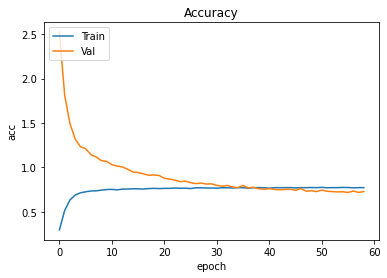

In [48]:


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['Train', 'Val'], loc='upper left')

In [49]:
model.save('models/v7')

INFO:tensorflow:Assets written to: models/v7\assets
